## <font color='navy'> Examen 2. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> Modelos de Clasificación

    
Luis Fernando Márquez Bañuelos

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn import discriminant_analysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


## <font color='navy'> Explicación de variables

1. **`gender`** (Categórica):  
   - **Descripción**: Género del paciente.  
   - **Valores posibles**: `Female` (mujer), `Male` (hombre).  

2. **`age`** (Numérica):  
   - **Descripción**: Edad del paciente en años.  

3. **`hypertension`** (Binaria):  
   - **Descripción**: Indica si el paciente tiene hipertensión.  
   - **Valores**: `0` (no), `1` (sí).  

4. **`heart_disease`** (Binaria):  
   - **Descripción**: Indica si el paciente tiene enfermedades cardíacas.  
   - **Valores**: `0` (no), `1` (sí).  

5. **`smoking_history`** (Categórica):  
   - **Descripción**: Historial de tabaquismo del paciente.  
   - **Valores posibles**:  
     - `never`: Nunca ha fumado.  
     - `former`: Exfumador.  
     - `current`: Fumador actual.  
     - `No Info`: Datos no proporcionados.  
     - `ever`: Alguna vez ha fumado (poco común).  
     - `not current`: No fuma actualmente.  

6. **`bmi`** (Numérica):  
   - **Descripción**: Índice de Masa Corporal (BMI, por sus siglas en inglés).  

7. **`diabetes`** (Binaria):  
   - **Descripción**: Diagnóstico de diabetes (variable objetivo).  
   - **Valores**: `0` (no tiene diabetes), `1` (tiene diabetes).  

## <font color='navy'> Funciones

In [3]:
def histograma_variables(data: pd.DataFrame, numerical_features: list):
    for i in range(len(numerical_features)):
        plt.hist(data[numerical_features[i]], bins = 20, color = 'skyblue', edgecolor = 'black')
        plt.title(numerical_features[i])
        plt.show()

def boxplot_variables(data: pd.DataFrame, numerical_features: list):
    fig, axes = plt.subplots(1, len(numerical_features), figsize=(12, 6))
    for ax, feature in zip(axes, numerical_features):
        ax.boxplot(data[feature].dropna())
        ax.set_title(feature)
    plt.suptitle("Boxplots of Numerical Features")
    plt.tight_layout()
    plt.show()

In [4]:
class ClassificationModels:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        self.params_log = {
        'poly__degree': [1, 2, 3],
        'logreg__penalty': [None, 'l2'],
        'logreg__C': [0.01, 0.1, 1]
        }

        self.params_knn = {
        'knn__n_neighbors': range(1, 30),
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
        }

        self.params_red = {
        'red__hidden_layer_sizes': [(5,5,5), (100,), (10,10)],
        'red__activation': ['tanh', 'relu', 'logistic'],
        'red__alpha': [0.1, 0.01]
        }

    def histograma(self, probabilidades: np.ndarray, modelo: str):
        juntar = pd.DataFrame({
        'real': self.y_test,
        'probabilidades': probabilidades
        })
        plt.figure(figsize=(10, 5))
        plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
        plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
        plt.title(f'Histograma de probabilidades de {modelo}')
        plt.legend()
        plt.show()
        print()
    
    def calibracion(self, probabilidades: np.ndarray, modelo: str, bins = 10):
        calibracion = pd.DataFrame({
        'target': self.y_test, 
        'probabilidades': probabilidades
        })

        calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=bins, labels=False, duplicates='drop') + 1
        grouped = calibracion.groupby('bins').mean()
        
        plt.figure(figsize=(10, 5))
        plt.plot(grouped.probabilidades, grouped.target, marker="o", c = 'skyblue')
        plt.plot(grouped.probabilidades, grouped.probabilidades, marker='o', c="indianred")
        plt.xlabel("Probabilidad")
        plt.ylabel("Real")
        plt.title(f'Gráfica de calibración de {modelo}')
        plt.grid()
        plt.show()

    def roc_curve(self, probabilidades: np.ndarray, modelo: str):
        fpr, fnp, _ = roc_curve(y_score=probabilidades, y_true=self.y_test)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, fnp, c='skyblue')
        plt.plot([0, 1], [0, 1], c='indianred')
        plt.title(f'Curva ROC de {modelo}')
        plt.show()

    def logistic_regression(self):
        pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=10000, random_state=42))
        ])

        random_search = RandomizedSearchCV(pipeline, param_distributions=self.params_log, 
                                           n_iter=15, cv=5, scoring='roc_auc', random_state=42)
        random_search.fit(self.X_train, self.y_train)

        degree = random_search.best_params_['poly__degree']
        probabilidades = random_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        feature_names = random_search.best_estimator_.named_steps['poly'].get_feature_names_out(self.X_train.columns)
        coefs = random_search.best_estimator_.named_steps['logreg'].coef_[0]
        df_coef = pd.DataFrame({
            'feature': feature_names, 
            'coefficient': coefs})
        
        display(df_coef)
        self.calibracion(probabilidades, modelo=f'regresión logística grado {degree}')
        self.roc_curve(probabilidades, modelo=f'regresión logística grado {degree}')
        self.histograma(probabilidades, modelo=f'regresión logística grado {degree}')
        return auc

    def discriminant_analysis(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades, modelo='discriminante lineal')
        self.roc_curve(probabilidades, modelo='discriminante lineal')
        self.histograma(probabilidades, modelo='discriminante lineal')
        return auc
    
    def knn_classification(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())  
        ])

        random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=self.params_knn, 
                                   n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc', random_state=42)
        random_search.fit(self.X_train, self.y_train)

        opt_nn = random_search.best_params_['knn__n_neighbors']
        probabilidades = random_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)
        
        self.calibracion(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        self.roc_curve(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        self.histograma(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        return auc
    
    def red_neuronal(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('red', MLPClassifier(max_iter=1000, random_state=42))
        ])

        grid_search = GridSearchCV(estimator=pipeline, param_grid=self.params_red, cv=5, n_jobs=-1, scoring='roc_auc')
        grid_search.fit(self.X_train, self.y_train)

        probabilidades = grid_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades, modelo='red neuronal')
        self.roc_curve(probabilidades, modelo='red neuronal')
        self.histograma(probabilidades, modelo='red neuronal')
        return auc
    
    def run_models(self):
        modelos = [
            'Regresión Logística',
            'KNN',
            'Análisis Discriminante',
            'Red Neuronal'
        ]

        aucs = [
            self.logistic_regression(),
            self.knn_classification(),
            self.discriminant_analysis(),
            self.red_neuronal()
        ]
        aucs = np.array(aucs)
        resultados = pd.DataFrame({
            'modelos': modelos,
            'auc': aucs,
            'gini': (2 * aucs) -1
        })
        return resultados

## <font color='navy'> Análisis de Datos

In [5]:
data = pd.get_dummies(data, columns=['gender', 'smoking_history'])
target = 'diabetes'
data.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,True,False,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,True,False,False,True,False,False,False,False,False
2,28.0,0,0,27.32,0,False,True,False,False,False,False,False,True,False
3,36.0,0,0,23.45,0,True,False,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,False,True,False,False,True,False,False,False,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  float64
 1   hypertension                 100000 non-null  int64  
 2   heart_disease                100000 non-null  int64  
 3   bmi                          100000 non-null  float64
 4   diabetes                     100000 non-null  int64  
 5   gender_Female                100000 non-null  bool   
 6   gender_Male                  100000 non-null  bool   
 7   gender_Other                 100000 non-null  bool   
 8   smoking_history_No Info      100000 non-null  bool   
 9   smoking_history_current      100000 non-null  bool   
 10  smoking_history_ever         100000 non-null  bool   
 11  smoking_history_former       100000 non-null  bool   
 12  smoking_history_never        100000 non-null  bool   
 13  

## <font color='navy'> Modelos Base

In [7]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
models = ClassificationModels(X, y)

,feature,coefficient
0,age,0.926197
1,hypertension,0.182260
2,heart_disease,0.177491
3,bmi,0.581331
4,gender_Female,-0.042116
...,...,...
99,smoking_history_former smoking_history_never,0.000000
100,smoking_history_former smoking_history_not cur...,0.000000
101,smoking_history_never^2,-0.026429
102,smoking_history_never smoking_history_not current,0.000000


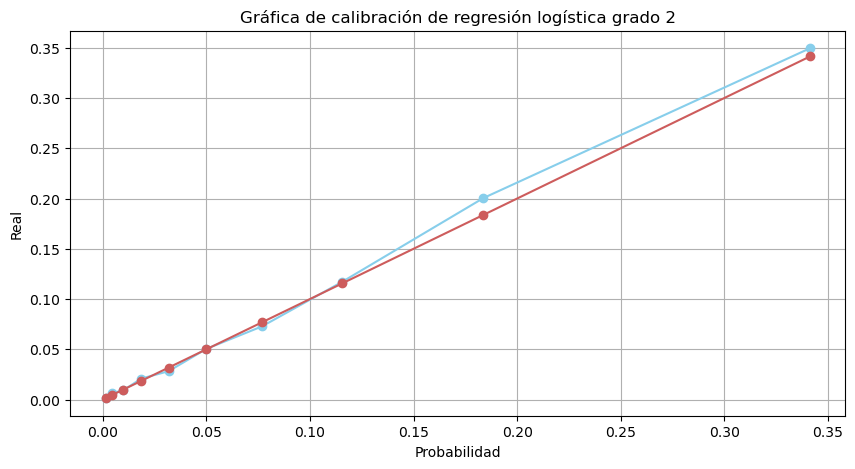

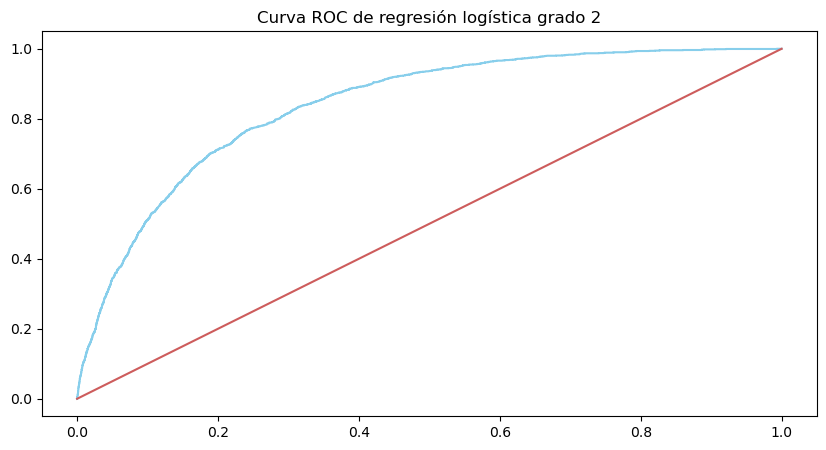

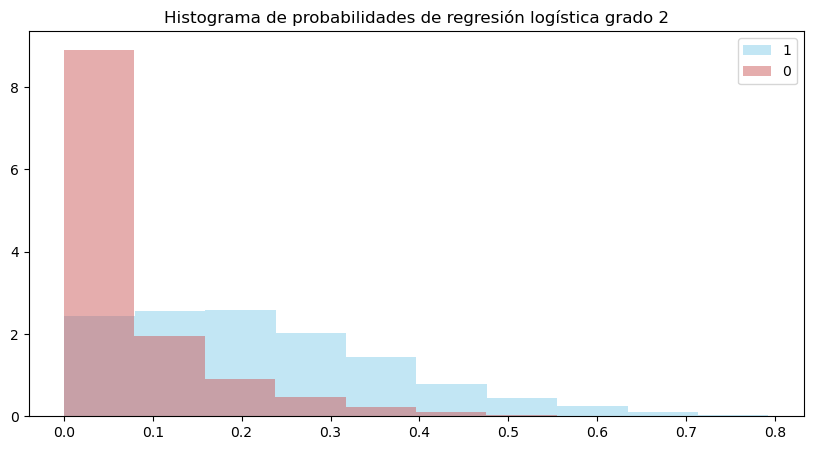

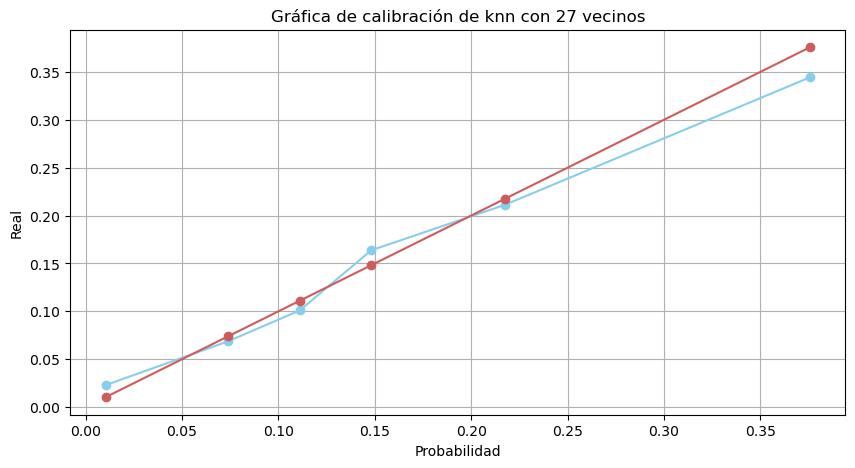

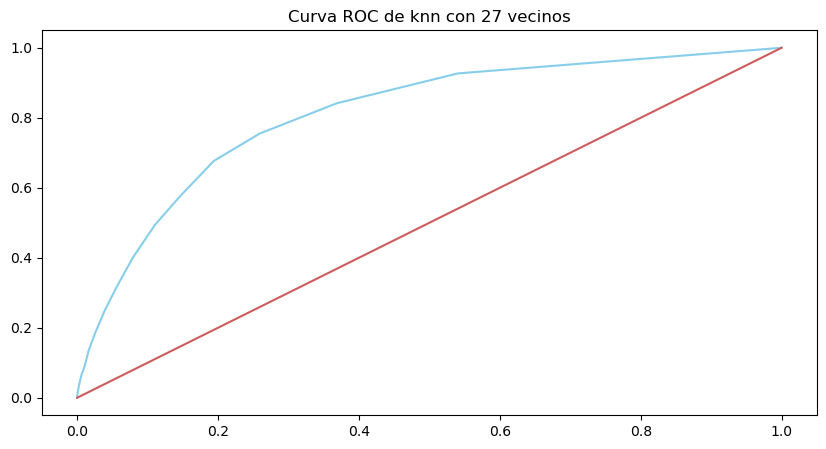

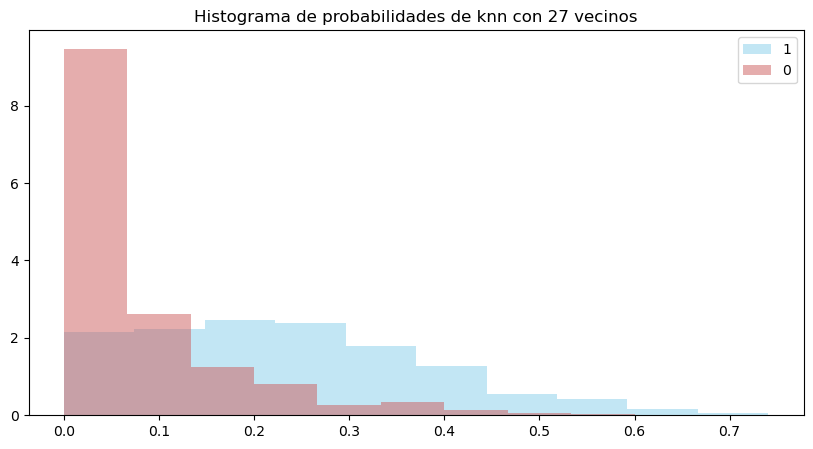

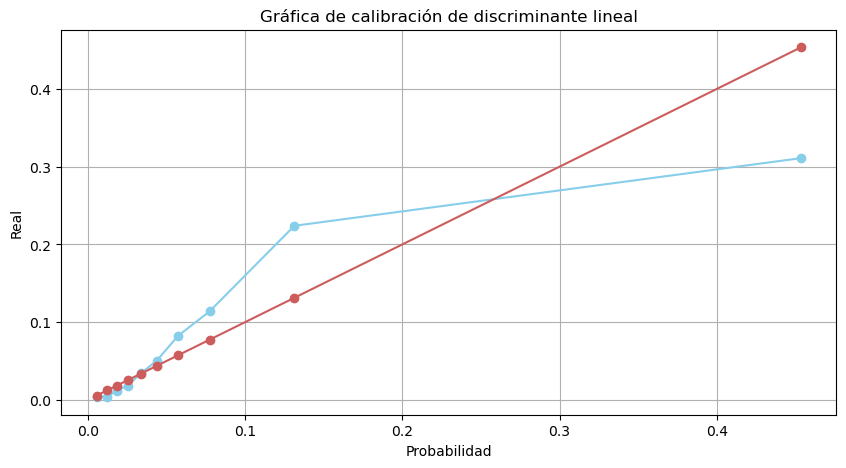

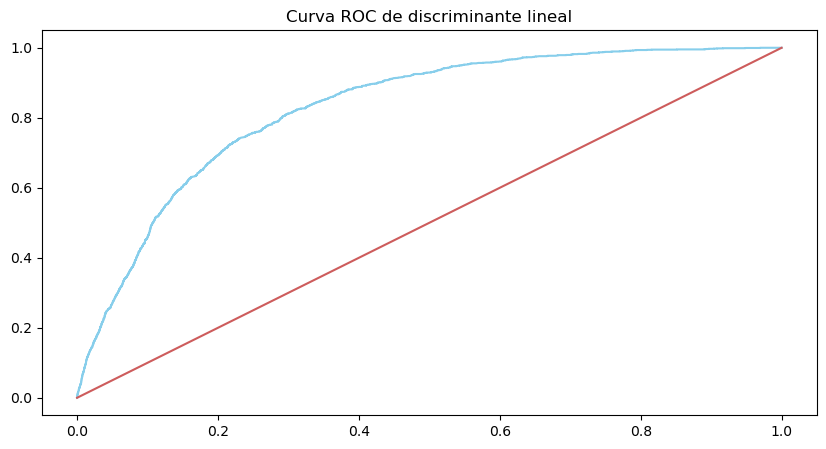

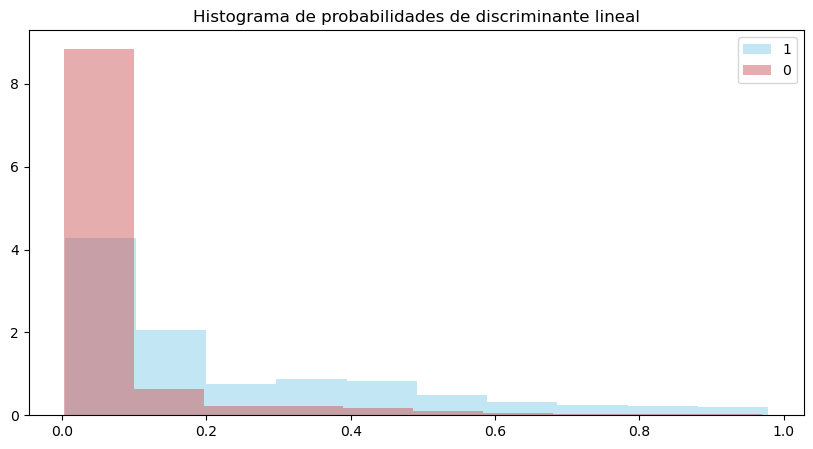

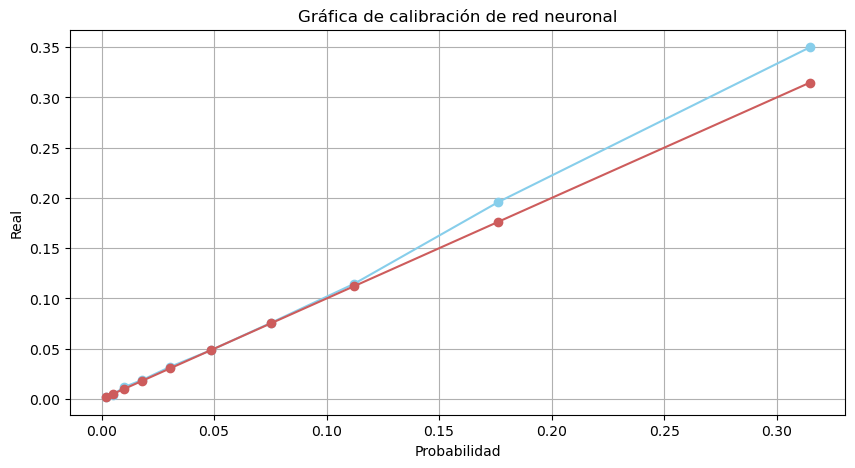

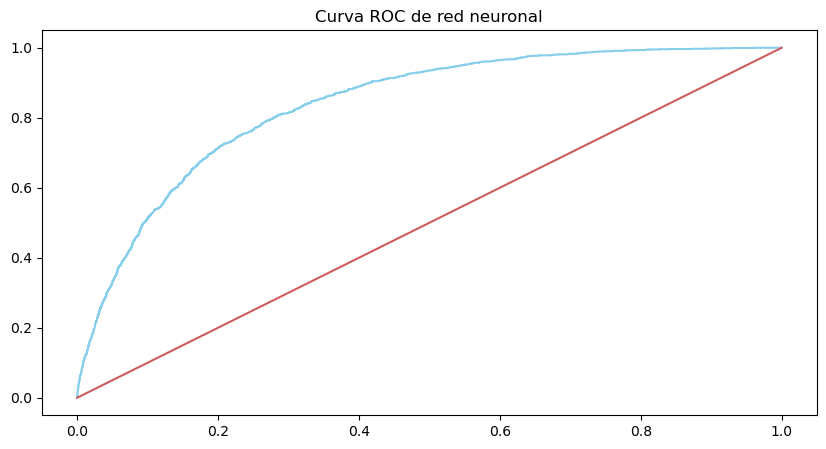

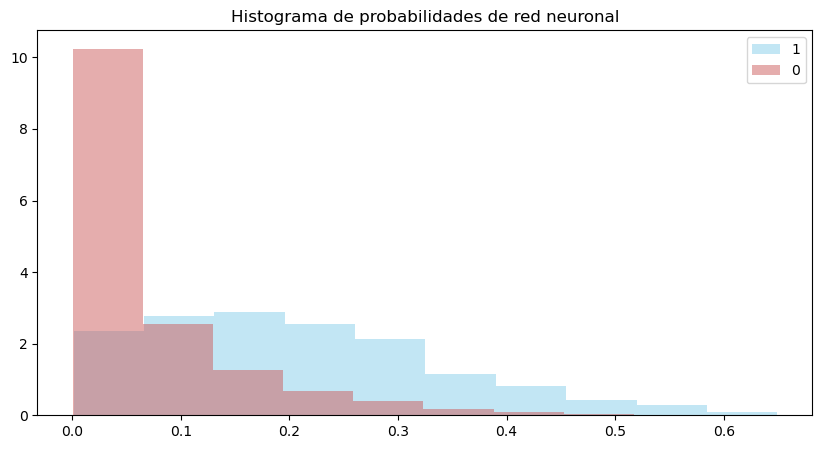

,modelos,auc,gini
0,Regresión Logística,0.838536,0.677072
1,KNN,0.810369,0.620737
2,Análisis Discriminante,0.827925,0.655850
3,Red Neuronal,0.837756,0.675512


In [9]:
models.run_models()

## <font color='navy'> Feature Engineering

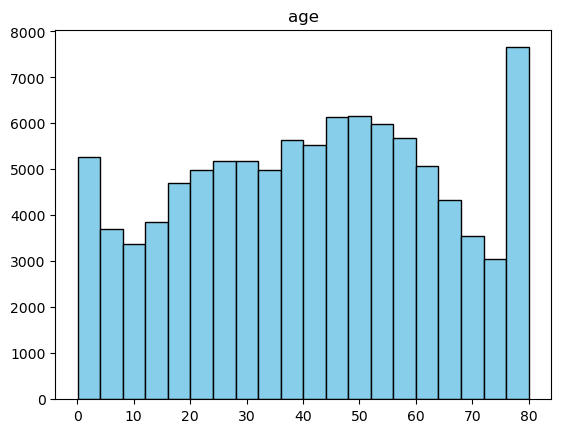

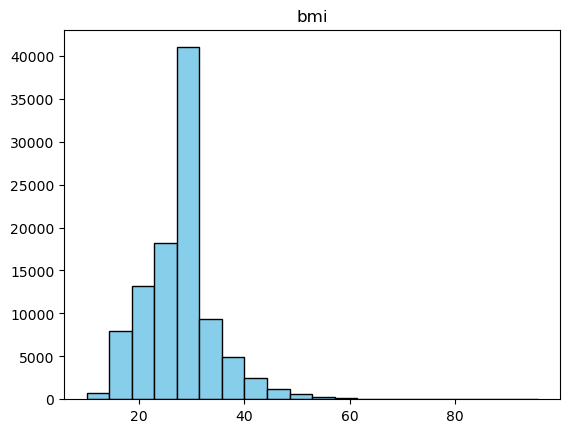

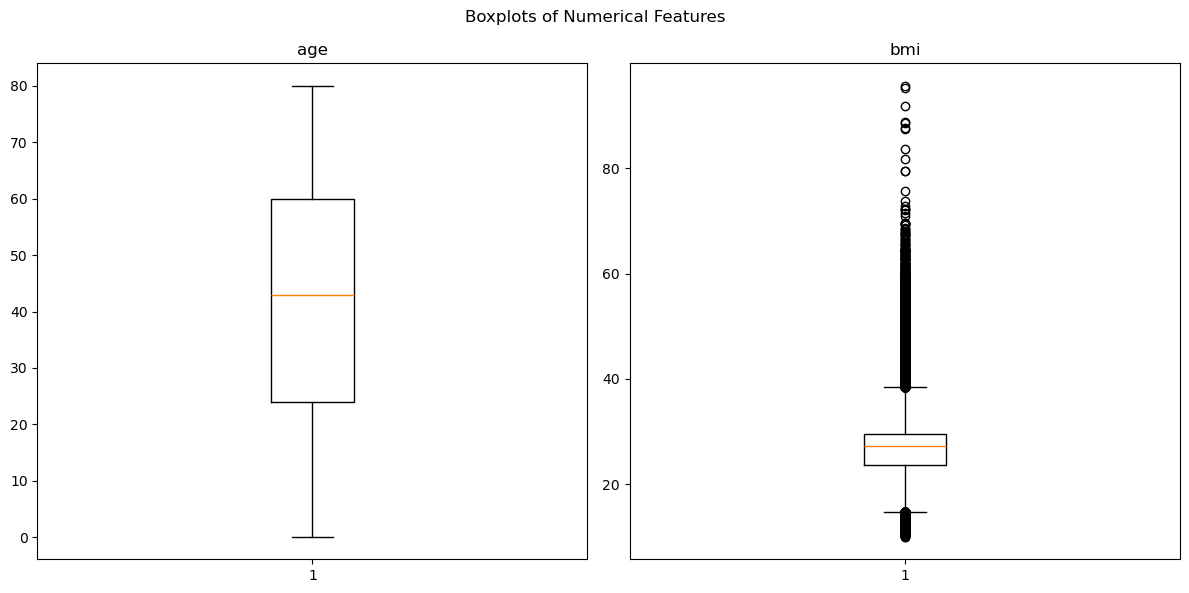

In [10]:
numerical_features = ['age', 'bmi']

histograma_variables(data, numerical_features)
boxplot_variables(data, numerical_features)